## Load packages

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import gc
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from sklearn import metrics 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2023


## Read the Data

In [2]:
df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# checking data 
print("Fraud Detection data -  rows:",df.shape[0]," columns:", df.shape[1])

Fraud Detection data -  rows: 6362620  columns: 11


In [4]:
# Let's look into more details to the data.
df.describe().astype(int)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620
mean,243,179861,833883,855113,1100701,1224996,0,0
std,142,603858,2888242,2924048,3399180,3674128,0,0
min,1,0,0,0,0,0,0,0
25%,156,13389,0,0,0,0,0,0
50%,239,74871,14208,0,132705,214661,0,0
75%,335,208721,107315,144258,943036,1111909,0,0
max,743,92445516,59585040,49585040,356015889,356179278,1,1


In [5]:
# checking if there is any missing data.
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
# checking data unbalance with respect with *target* value, i.e. isFraud.

temp = df["isFraud"].value_counts()
data = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = data['Class'],y = data['values'],
    name="Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Blue"),
    text=data['values']
)
data_df = [trace]
layout = dict(title = 'Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Fraud', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data_df, layout=layout)
iplot(fig, filename='class')

## Data Exploration

In [8]:
# checking for transactions of every customer and merchant 

m_c = 0 
c_c = 0  
fm_c = 0
fc_c = 0

for i,j in zip(df.nameDest,df.isFraud):
    if j == 0:
        if 'C' in i: c_c += 1
        elif 'M' in i: m_c += 1
    elif j == 1:
        if 'C' in i: fc_c += 1
        elif 'M' in i: fm_c += 1

f_df = pd.DataFrame({'Fraud':[0,1],'Customer':[c_c,fc_c],'Merchant':[m_c,fm_c]})
f_df

,Fraud,Customer,Merchant
0,0,4202912,2151495
1,1,8213,0


Fraudulent transactions only occuerd in Customer to Customer transactions.

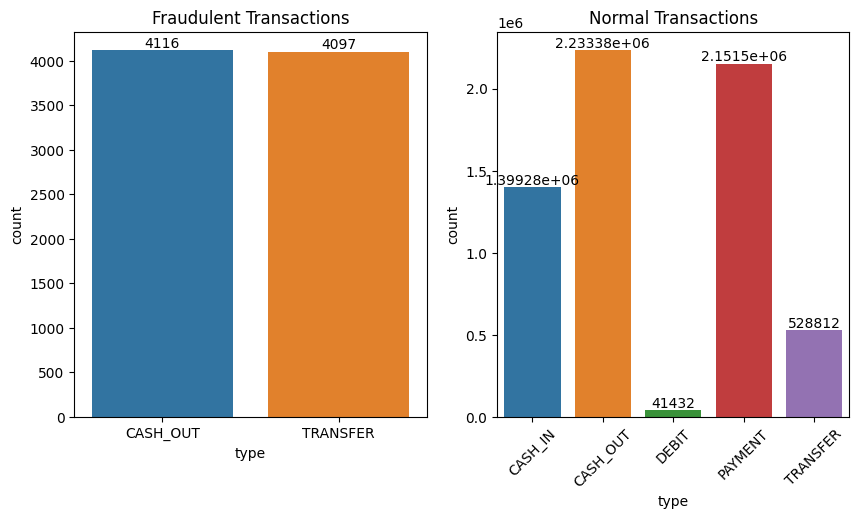

In [9]:
# checking for all type of transactions including Fraudulent and Normal both

f_df = pd.DataFrame(df[df.isFraud == 0].groupby(['type'])['isFraud'].value_counts()).rename(columns= {'isFraud':'count'}).reset_index()
n_df = pd.DataFrame(df[df.isFraud == 1].groupby(['type'])['isFraud'].value_counts()).rename(columns= {'isFraud':'count'}).reset_index()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax = sns.barplot(ax = ax1, x="type", y="count",data=n_df)
ax.bar_label(ax.containers[0])
ax.set(title='Fraudulent Transactions')
ax1 = sns.barplot(ax = ax2, x="type", y="count",data=f_df)
ax1.bar_label(ax1.containers[0])
ax1.set(title='Normal Transactions')
plt.xticks(rotation = 45)
plt.show();

In [10]:
# transactions throughout time.

class_0 = df.loc[df['isFraud'] == 0]["step"]
class_1 = df.loc[df['isFraud'] == 1]["step"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Transactions Time Density Plot', xaxis=dict(title='Time [h]'))
iplot(fig, filename='dist_only')

Fraudulent transactions have a distribution more even than valid transactions, that are equaly distributed in time.

In [11]:
# total amount of transactions in Fraudulent and Normal both

data = pd.DataFrame(df.groupby(['isFraud'])['amount'].sum()).reset_index()
trace = go.Bar(
    x = data['isFraud'],y = data['amount'],
    name="Amount in Normal and Fraudulent transaction",
    marker=dict(color="Blue"),
    text=data['amount']
)
data_df = [trace]
layout = dict(title = 'Amount in Normal and Fraudulent transaction',
          xaxis = dict(title = 'Fraud', showticklabels=True), 
          yaxis = dict(title = 'Total Amount'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data_df, layout=layout)
iplot(fig, filename='fraud')

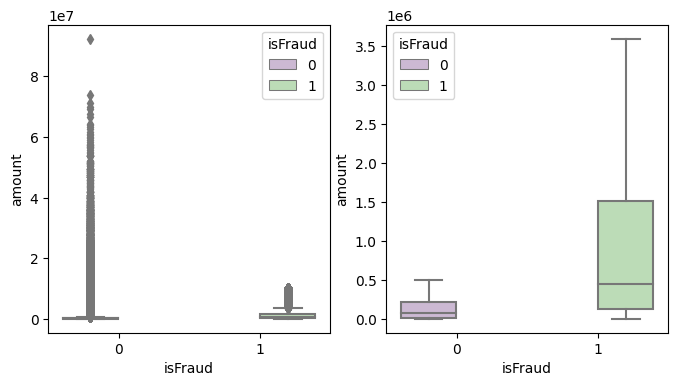

In [12]:
# transaction amount

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))
s = sns.boxplot(ax = ax1, x="isFraud", y="amount", hue="isFraud",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="amount", hue="isFraud",data=df, palette="PRGn",showfliers=False)
plt.show();

In [13]:
tmp = df[['amount','isFraud']].copy()
class_0 = tmp.loc[tmp['isFraud'] == 0]['amount']
class_1 = tmp.loc[tmp['isFraud'] == 1]['amount']
class_0.describe().astype(int)

count     6354407
mean       178197
std        596236
min             0
25%         13368
50%         74684
75%        208364
max      92445516
Name: amount, dtype: int32

In [14]:
class_1.describe().astype(int)

count        8213
mean      1467967
std       2404252
min             0
25%        127091
50%        441423
75%       1517771
max      10000000
Name: amount, dtype: int32

The fraudulent transactions have a larger mean, larger Q1, Q3 and Q4.

Let's plot the fraudulent transactions (amount) against time. The time is shown is hours from the start of the time period.

In [15]:
fraud = df.loc[df['isFraud'] == 1]

trace = go.Scatter(
    x = fraud['step'],y = fraud['amount'],
    name="amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [h]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

## Features Correlation

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1476\1169799235.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



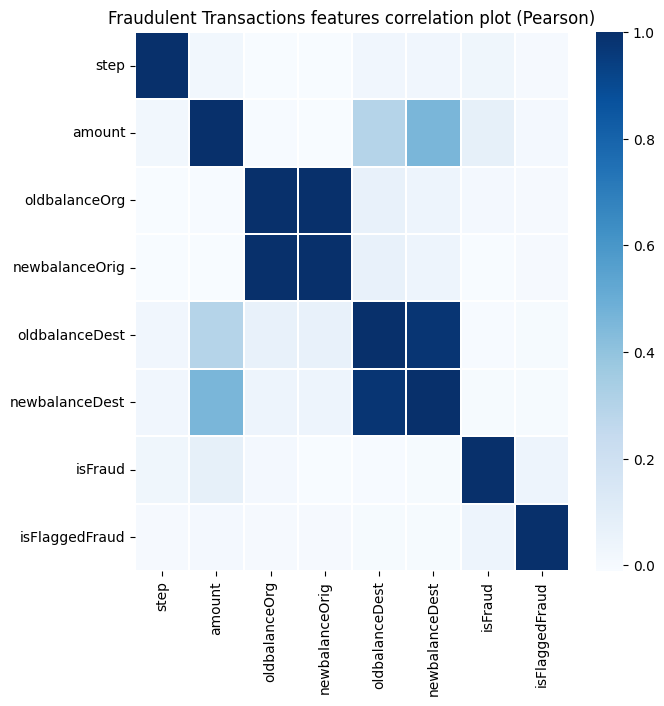

In [16]:
plt.figure(figsize = (7,7))
plt.title('Fraudulent Transactions features correlation plot (Pearson)')
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.05,cmap="Blues")
plt.show()

There are certain correlations between some of these features and **amount** (correlation with **oldbalanceDest,newbalanceDest**) and direct correlation b/w **oldbalanceOrig** and **newbalanceOrig** and in **oldbalanceDest** and **newbalanceDest**.

Now lets check the VIF table for more info.

In [17]:
# converting all object type columns into float type. so we can get better results in vif table.

for column in df:
    if df[column].dtypes == object:
        enc = OrdinalEncoder()
        enc.fit(df[[column]])
        df[column] = enc.transform(df[[column]])

In [18]:
#Compute VIF data for each independent variable
vif = pd.DataFrame()
vif["features"] = df.columns
vif["vif_Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif

,features,vif_Factor
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


As we can see the vif factor for 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest' is very high(ideal vif factor shoul be less than 10), so this introduces multicolinarity in our features.

Lets try removing some features to reduce multicolinarity.

In [19]:
df['amountTransferedOrg'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['amountTransferedDest'] = df['oldbalanceDest'] - df['newbalanceDest']
df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1 ,inplace= True)

In [20]:
kdf = df[['step', 'type', 'amount', 'nameOrig', 'amountTransferedOrg', 'nameDest', 'amountTransferedDest', 'isFraud', 'isFlaggedFraud']]
vif = pd.DataFrame()
vif["features"] = kdf.columns
vif["vif_Factor"] = [variance_inflation_factor(kdf.values, i) for i in range(kdf.shape[1])]
vif

,features,vif_Factor
0,step,2.716281
1,type,4.311403
2,amount,3.972755
3,nameOrig,2.686866
4,amountTransferedOrg,1.339171
5,nameDest,3.261088
6,amountTransferedDest,3.790322
7,isFraud,1.190013
8,isFlaggedFraud,1.002563


Just by making 2 features out of 4 features with highest vif factor, we get all the features with less than 10 vif factor. Two new factors that are made are the amount transfered in sender and recipitent account (i.e. amountTransferedOrg, amountTransferedDes).

If we select these new features in our training dataset it will help in a better model.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1476\2436954462.py:13: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1476\2436954462.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1476\2436954462.py:13: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1476\2436954462.py:14: UserWarning:



The `bw` paramet

<Figure size 640x480 with 0 Axes>

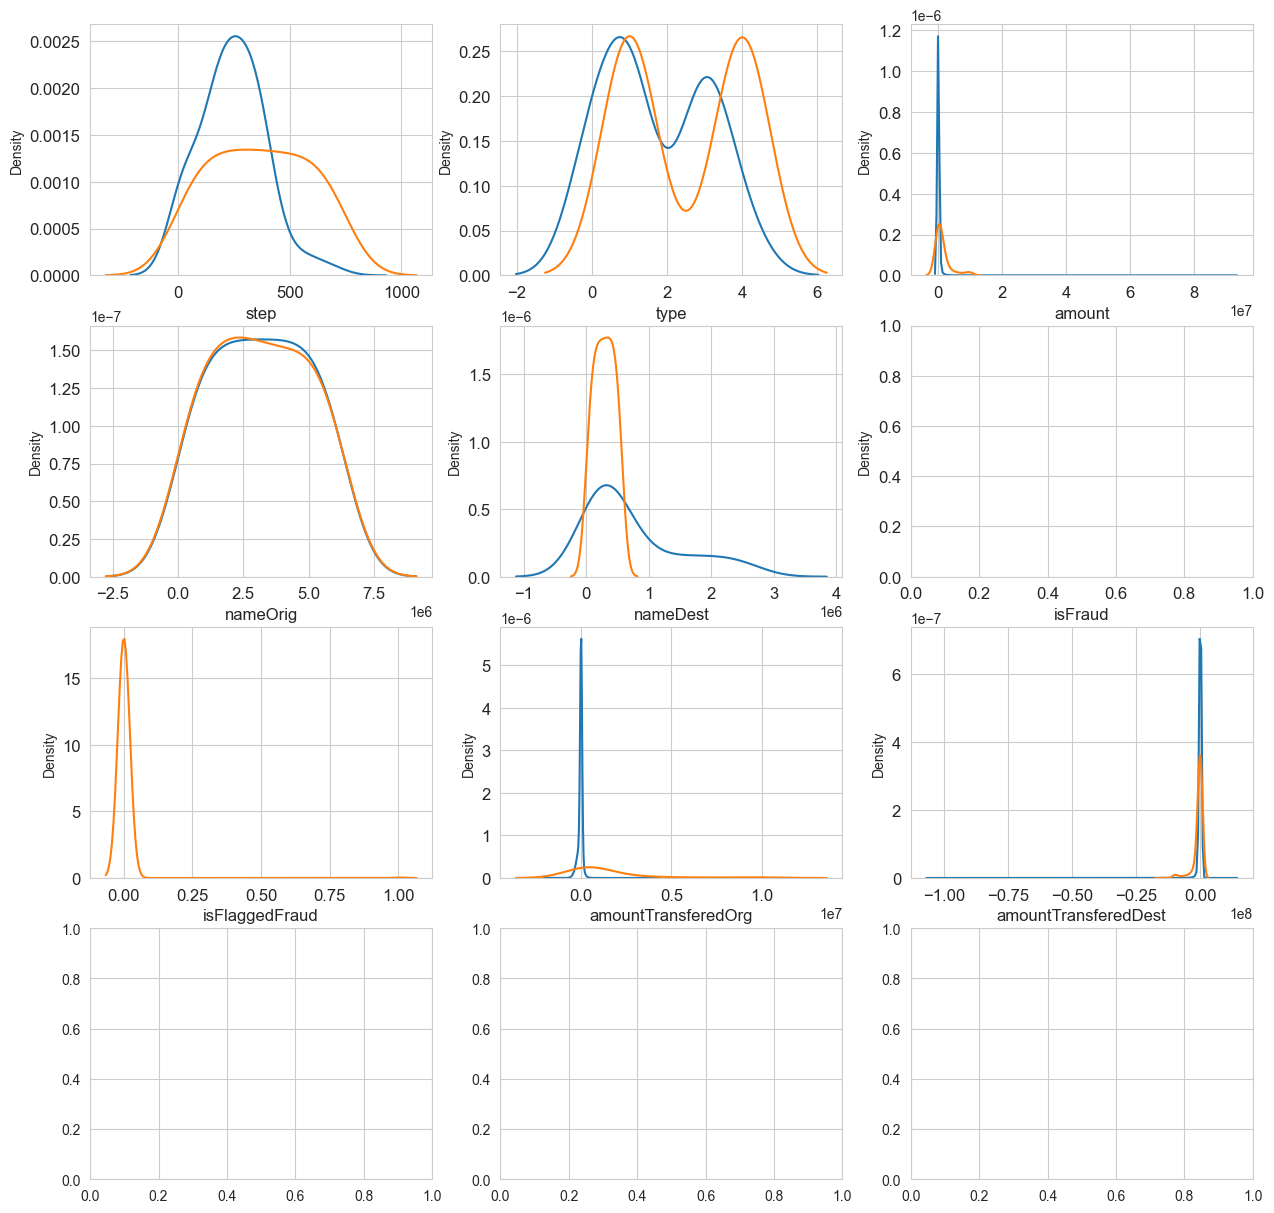

In [21]:

var = df.columns.values

i = 0
t0 = df.loc[df['isFraud'] == 0]
t1 = df.loc[df['isFraud'] == 1]
 
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,3,figsize=(15,15))
for feature in var:
    i += 1
    plt.subplot(4,3,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

For some of the features we can observe a good selectivity in terms of distribution for the two values of **isFraud**: **step**, **nameDest** have clearly separated distributions, while every other features have almost similar profiles for the two values of **inFraud**.  

In general, with just few exceptions (**step** and **type**), the features distribution for legitimate transactions (values of **isFraud = 0**)  is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of **isFraud = 1**) have a skewed (asymmetric) distribution.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1476\312211508.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1476\312211508.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1476\312211508.py:7: UserWarning:



`distplot` is a 

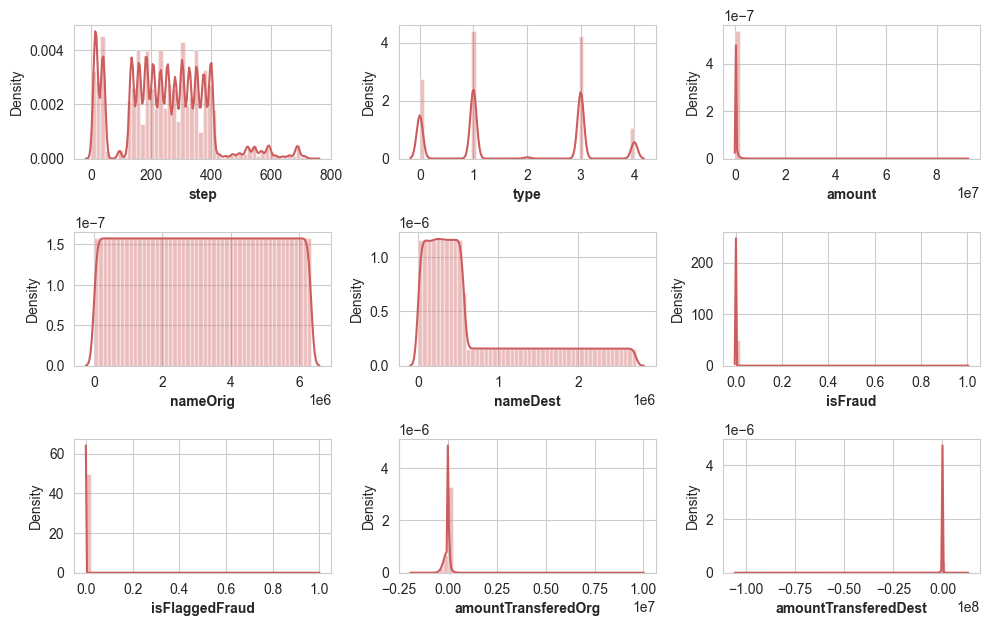

In [22]:
# kdf = df[['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest']]
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(10, 8))
for i, col in enumerate(numeric_features):
    plt.subplot(4,3,i+1)
    sns.distplot(x=df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

**Report**
- As per the above plot most of the features are not normally distributed.

## Predictive models

In [23]:
# making a function for evaluation matric
# it will return a dataframe with every evaluation matrics 

def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    data = {'Accuracy':acc, 'F1_Score':f1,'Pecision':precision,'Recall':recall,'Area Under Curve':roc_auc}
    report=pd.DataFrame(data,index=[1])
    return report

### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there were
3 categorical features which were transformed into numerical features through ordinal encodng.

In [27]:
target= 'isFraud'
predictors = ['step', 'type', 'amount', 'nameOrig', 'amountTransferedOrg', 'nameDest', 'amountTransferedDest', 'isFlaggedFraud']

In [28]:
# Split data in train, test and validation set
# Let's define train, validation and test sets.

train_df, test_df= train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [29]:
# now scaling the numerical data using robust scaler.

robustscaler = RobustScaler()
train_df_predictors = robustscaler.fit_transform(train_df[predictors])
valid_df_predictors = robustscaler.fit_transform(valid_df[predictors])

**Why Robust scaler and not Standard scaler?**
- Since most of the independent variables are not normally distributed we cannot use Standardscaler

**Why Robust Scaler and not Minmax?** 
- because most of the feature has outliers. So Minmax will scale data according to Max values which is outlier.
- This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [30]:
# checking the training and validation dataset
print('shape of training dataset:- ',train_df_predictors.shape,'|  shape of validation dataset:- ',valid_df_predictors.shape)

shape of training dataset:-  (4072076, 8) |  shape of validation dataset:-  (1018020, 8)


### Let's start with a RandomForrestClassifier

In [31]:
clf = RandomForestClassifier(random_state= RANDOM_STATE)

clf.fit(train_df_predictors, train_df[target].values)

RandomForestClassifier(random_state=2023)

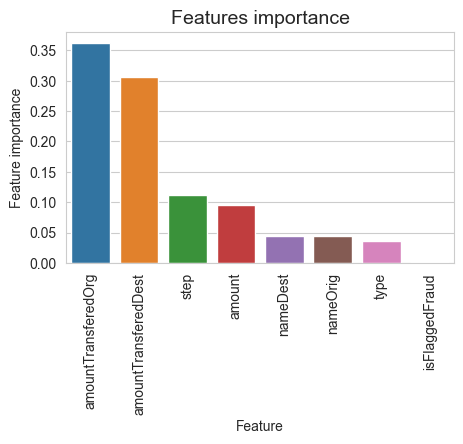

In [32]:
# Let's also visualize the features importance.
# Features importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (5,3))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

The most important features are **type** and **amount** and least important feature is **nameOrig** and **isFlaggedFraud** 


### Confusion matrix

Let's show a confusion matrix for the results we obtained.

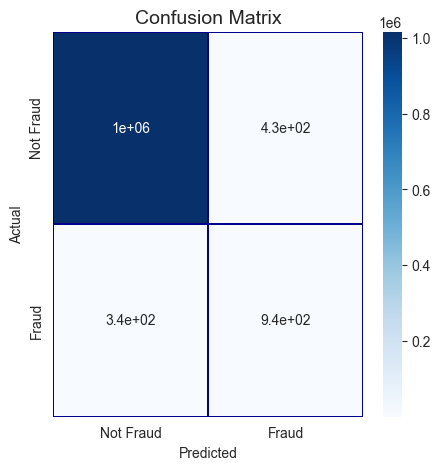

In [33]:
preds = clf.predict(valid_df_predictors)

cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [34]:
# report for every evaluation matrics
report = evaluate_clf(valid_df[target].values, preds)
report

,Accuracy,F1_Score,Pecision,Recall,Area Under Curve
1,0.999246,0.710407,0.687591,0.734789,0.867184


### now using AdaBoostClassifier 

And implimenting every steps that are used in above model
- training and fitting 
- feature importance
- confusion matrix
- evaluation matrix

In [35]:
ada_clf = AdaBoostClassifier(random_state= RANDOM_STATE)

ada_clf.fit(train_df_predictors, train_df[target].values)

AdaBoostClassifier(random_state=2023)

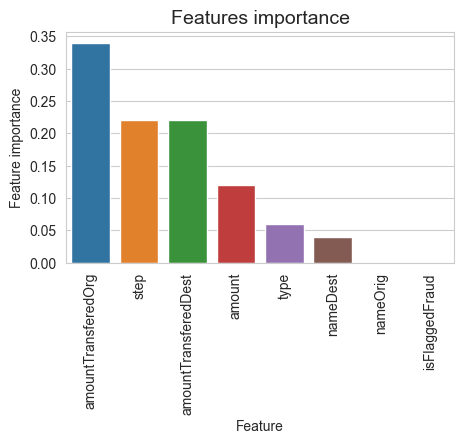

In [36]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': ada_clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (5,3))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

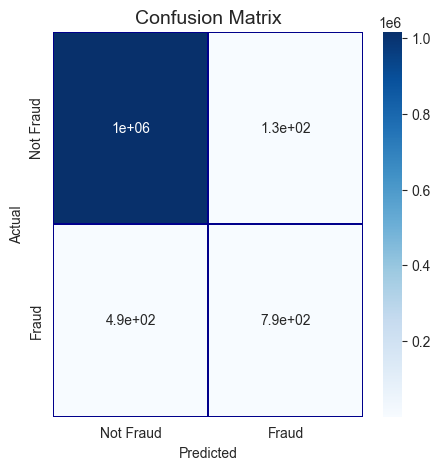

In [37]:
preds = ada_clf.predict(valid_df_predictors)

cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [38]:
report = evaluate_clf(valid_df[target].values, preds)
report

,Accuracy,F1_Score,Pecision,Recall,Area Under Curve
1,0.999385,0.716228,0.854978,0.616225,0.808046


### now using CatBoostClassifier 

And implimenting every steps that are used in above model
- training and fitting 
- feature importance
- confusion matrix
- evaluation matrix

In [48]:
cat_clf = CatBoostClassifier(random_state= RANDOM_STATE)

cat_clf.fit(train_df_predictors, train_df[target].values)

Learning rate set to 0.358365
0:	learn: 0.0712191	total: 646ms	remaining: 10m 45s
1:	learn: 0.0124102	total: 1.3s	remaining: 10m 46s
2:	learn: 0.0043037	total: 1.87s	remaining: 10m 23s
3:	learn: 0.0031391	total: 2.38s	remaining: 9m 53s
4:	learn: 0.0027172	total: 2.85s	remaining: 9m 27s
5:	learn: 0.0024756	total: 3.34s	remaining: 9m 13s
6:	learn: 0.0024171	total: 3.82s	remaining: 9m 1s
7:	learn: 0.0022802	total: 4.33s	remaining: 8m 57s
8:	learn: 0.0021976	total: 4.81s	remaining: 8m 49s
9:	learn: 0.0021426	total: 5.27s	remaining: 8m 42s
10:	learn: 0.0021102	total: 5.76s	remaining: 8m 38s
11:	learn: 0.0020860	total: 6.24s	remaining: 8m 33s
12:	learn: 0.0020419	total: 6.79s	remaining: 8m 35s
13:	learn: 0.0020056	total: 7.27s	remaining: 8m 32s
14:	learn: 0.0019846	total: 7.78s	remaining: 8m 30s
15:	learn: 0.0019650	total: 8.28s	remaining: 8m 28s
16:	learn: 0.0019437	total: 8.8s	remaining: 8m 28s
17:	learn: 0.0019349	total: 9.34s	remaining: 8m 29s
18:	learn: 0.0019252	total: 9.81s	remaining:

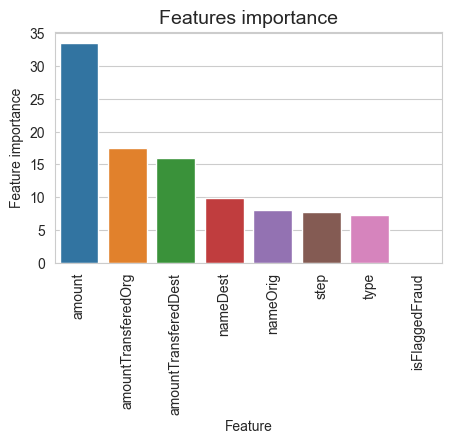

In [49]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': cat_clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (5,3))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

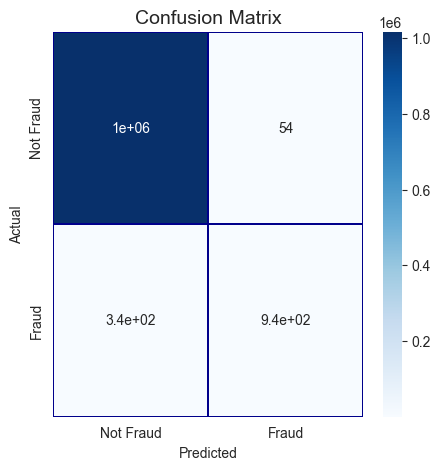

In [50]:
preds = cat_clf.predict(valid_df_predictors)

cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [51]:
report = evaluate_clf(valid_df[target].values, preds)
report

,Accuracy,F1_Score,Pecision,Recall,Area Under Curve
1,0.999611,0.826011,0.945674,0.733229,0.866588


### now using XGBClassifier 

And implimenting every steps that are used in above model
- training and fitting 
- feature importance
- confusion matrix
- evaluation matrix

In [40]:
xgb_clf = xgb.XGBClassifier(random_state=RANDOM_STATE)

xgb_clf.fit(train_df_predictors, train_df[target].values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=2023, ...)

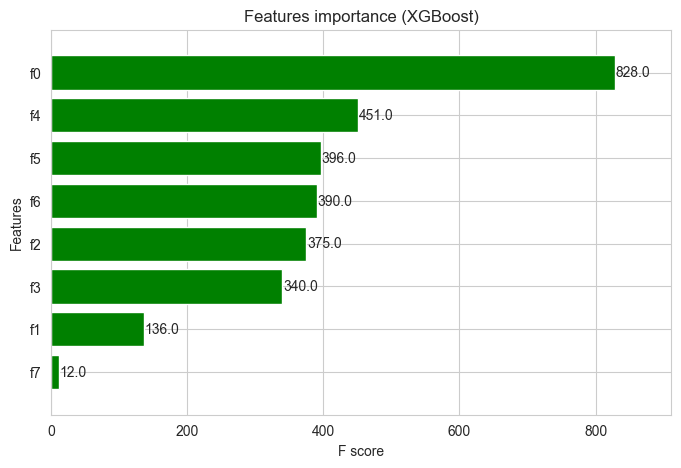

In [41]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(xgb_clf, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

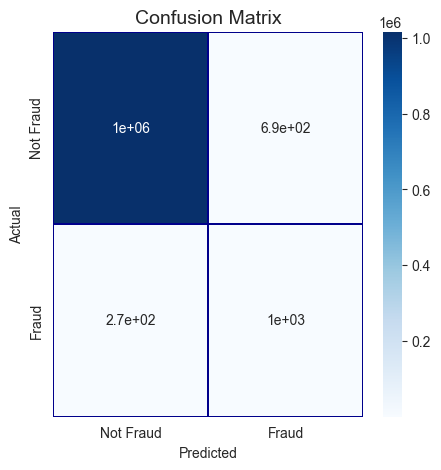

In [42]:
preds = xgb_clf.predict(valid_df_predictors)

cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [43]:
report = evaluate_clf(valid_df[target].values, preds)
report

,Accuracy,F1_Score,Pecision,Recall,Area Under Curve
1,0.999054,0.676954,0.593879,0.787051,0.893186


### now using LGBMClassifier 

And implimenting every steps that are used in above model
- training and fitting 
- feature importance
- confusion matrix
- evaluation matrix

In [44]:
lgb_clf = lgb.LGBMClassifier(random_state=RANDOM_STATE)

lgb_clf.fit(train_df_predictors, train_df[target].values)

LGBMClassifier(random_state=2023)

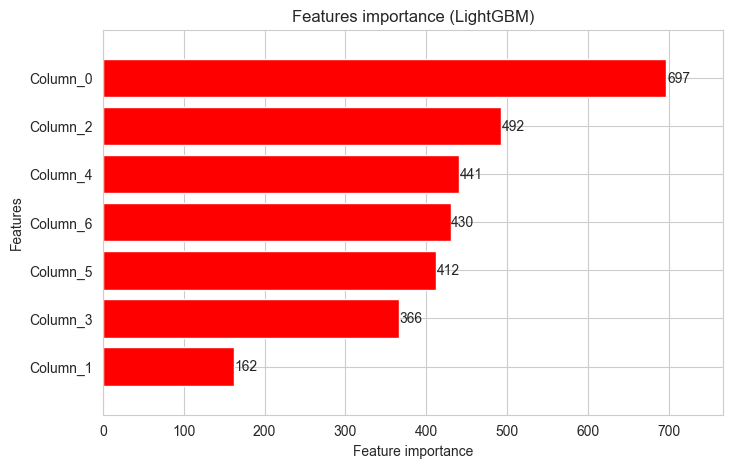

In [45]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(lgb_clf, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

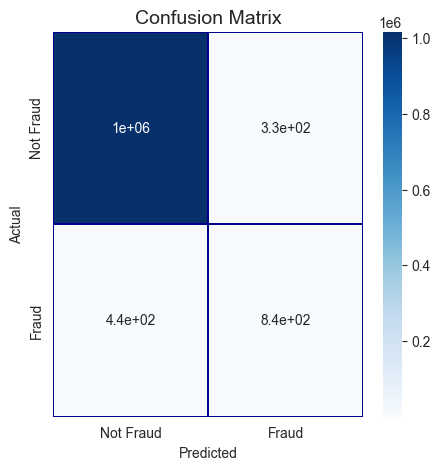

In [46]:
preds = lgb_clf.predict(valid_df_predictors)

cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [47]:
report = evaluate_clf(valid_df[target].values, preds)
report

,Accuracy,F1_Score,Pecision,Recall,Area Under Curve
1,0.999243,0.685947,0.717818,0.656786,0.82823


### The best model we got is CatBoostClassifier with it's overall best metrics.

In [52]:
# now to predict test data 

test_df_predictors = robustscaler.fit_transform(test_df[predictors])
preds = cat_clf.predict(test_df_predictors)

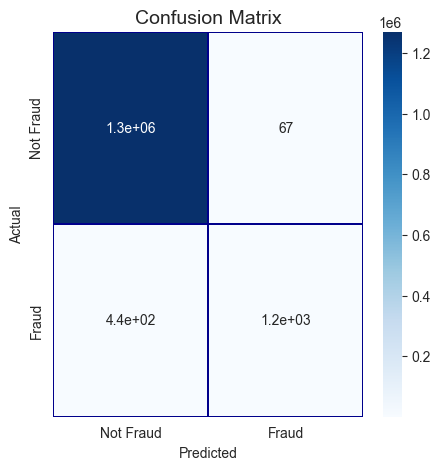

In [53]:
# confustion matrix for test predictions

cm = pd.crosstab(test_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

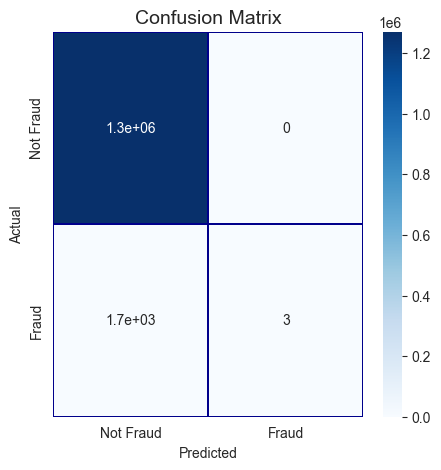

In [60]:
cm = pd.crosstab(test_df[target].values, test_df['isFlaggedFraud'].values, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [54]:
# evaluation report of catboost model

report = evaluate_clf(test_df[target].values, preds)
report

,Accuracy,F1_Score,Pecision,Recall,Area Under Curve
1,0.999604,0.829037,0.948022,0.736588,0.868268


In [61]:
# evaluation report of isflaggedfraud 

report = evaluate_clf(test_df[target].values, test_df['isFlaggedFraud'].values)
report

,Accuracy,F1_Score,Pecision,Recall,Area Under Curve
1,0.998699,0.00361,1.0,0.001808,0.500904


### As we can see that our predictive model(catboostclassifier) yeilds better result both in validation and test, and certainly better results than isFlaggedFraud values.  

In [ ]:
# So our final model will be 

final_model = cat_clf

More could have done with more time period like cross-validation or hyper parameter tuning.